<font size = 5>**Outflow of mobile operator customers from «Not-a-Single-Break.com»**</font>

## Project Description

The telecom operator "Not-a-Single-Break.com" wants to learn how to predict the outflow of customers. If it turns out that the user plans to leave, he will be offered promotional codes and special conditions. The operator's team collected personal data about some customers, information about their tariffs and contracts.

The operator provides two main types of services:

1. Fixed telephone connection. It is possible to connect a telephone set to several lines at the same time.
2. Internet. The connection can be of two types: via a telephone line (DSL *, * from the English * digital subscriber line *, "digital subscriber line") or fiber optic cable (* Fiber optic *).

The following services are also available:

- Internet security: antivirus (*DeviceProtection*) and blocking of unsafe sites (*OnlineSecurity*);
- Dedicated technical support line (*TechSupport*);
- Cloud file storage for data backup (*OnlineBackup*);
- Streaming TV (*StreamingTV*) and movie catalog (*StreamingMovies*).

Clients can pay for services every month or sign a contract for 1-2 years. Various payment methods and the possibility of receiving an electronic check are available.

### Data description

The data consists of files obtained from various sources:

- contract.csv — information about the contract;
- personal.csv — client's personal data;
- internet.csv - information about Internet services;
- phone.csv — information about telephony services.

In all files, the customerID column contains the customer ID.

Information about contracts is current as of February 1, 2020.

### Description of data fields from the Customer

- BeginDate - the date of the beginning of using the services,
- EndDate – end date of using the services,
- Type – contract type: monthly, annual, etc.,
- PaperlessBilling - the fact of invoicing by e-mail,
- PaymentMethod - payment method,
- MonthlyCharges - monthly spending on services,
- TotalCharges - total money spent on services,
- Dependents - the presence of dependents,
- Senior Citizen - the presence of a pension status by age,
- Partner - the presence of a spouse,
- MultipleLines – possibility to draw parallel lines during a call.

### Work purpose

Build a model to help predict customer exit.
- ROC-AUC metric is used for evaluation and training. Additionally, we can check - F1 and Accuracy.
- Minimum threshold for a successful model - AUC-ROC >= 0.85
- Additional condition: When dividing into samples, the ratio of training to test = 3/1.

### Project plan

1. Open and examine the data.
2. Analyze the data.
3. Prepare the data for training the model.
4. Train the models and conduct cross-validation, choose the best model
5. Consider the result of its work on the metric on the test sample.
6. General conclusion.

### Import everything we need

In [1]:
#!pip install scikit-learn==1.1.3

In [2]:
#pip install sweetviz

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

RANDOM_STATE = 300123

import warnings
warnings.filterwarnings('ignore')

## Data exploration

### Open and explore the data

In [4]:
try:
    contract = pd.read_csv('contract.csv')
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')
    phone = pd.read_csv('phone.csv')

except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

#### Contract

In [5]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
contract['customerID'].duplicated().sum()

0

**The data in the contract is as follows:**
1. customerID - encoded customer ID, they are the same in all tables.
2. BeginDate - start date, text format, must be in date format.
3. EndDate - end date of use, text format, must be in the date format, or No (ie the contract is valid). We could change the data of deceased to Yes, then it will be interesting for research, the date of their departure does not interest us, they left and left. We are interesting in the fact.
4. Type - subscription type (monthly, annual or two-year), text format, 3 options in total.
5. PaperlessBilling - email receipt, text, 2 options.
6. PaymentMethod - payment method, text format, several options.
7. MonthlyCharges - monthly spending on services, float format.
8. TotalCharges - TotalCharges - total money spent on services, text format, should be float format.

There are no passes. There are no duplicates (according to the customerID column, which means full rows of duplicates).

#### Internet

In [8]:
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
internet['customerID'].duplicated().sum()

0

**We have the following data on the internet:**
1. customerID - encoded customer ID, they are the same in all tables.
2. InternetService - connection type, text format, only two options.
3. OnlineSecurity - is the online firewall connected, text, 2 options.
4. OnlineBackup - cloud storage, text, 2 options.
5. DeviceProtection - is the antivirus connected, text, 2 options
6. TechSupport - dedicated support line, text, 2 options.
7. StreamingTV - whether streaming TV is connected, text, 2 options.

There are no passes. There are no duplicates (according to the customerID column, which means full rows of duplicates).

#### Personal

In [11]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [12]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [13]:
personal['customerID'].duplicated().sum()

0

**Data in Personal we have the following:**
1. customerID - encoded customer ID, they are the same in all tables.
2. gender - gender, text, 2 options.
3. SeniorCitizen - pensioner or not, categorical type (1 - pensioner, 0 - not pensioner).
4. Partner - the presence of a spouse, text, 2 options.
5. Dependents - the presence of dependents in the care of the client, text, 2 options.

There are no passes. There are no duplicates (according to the customerID column, which means full rows of duplicates).

#### Phone

In [14]:
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [15]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [16]:
phone['customerID'].duplicated().sum()

0

**We have the following data in phone:**
1. customerID - encoded customer ID, they are the same in all tables.
2. MultipleLines - the ability to conduct a parallel line during a call, text, 2 options.

There are no passes. There are no duplicates (according to the customerID column, which means full rows of duplicates).

### Brief overview of the data

1. The data is complete, there are no gaps in any table, in some tables it is necessary to change the data type for further use of data encoders into categorical ones. There are also no duplicates.
2. Different tables have a different number of rows, which means that when joining tables in the future (to create features for models), in some cases we will have empty rows.
3. Many columns with categorical data (which are currently indicated as Yes/No) will be coded in the future to be converted to digital categories (1/0).

## Data analysis

### Consider the contract table

In [17]:
# convert BeginDate to date and time format
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [18]:
# in the EndDate column, we will replace the dates with Yes so that we can categorically separate those who left from the rest.
contract.loc[contract['EndDate'] != 'No', 'EndDate'] = 'Yes'

In [19]:
# cast the values of the TotalCharges column to the float type. On the first try, it turned out
# that not all values are filled in, some are empty. Let's replace these values with 0.
# Next, let's calculate how many such lines we get.

contract['TotalCharges'] = contract['TotalCharges'].replace(' ', 0)

contract['TotalCharges'] = contract['TotalCharges'].astype(float)
len(contract[contract['TotalCharges']== 0])

11

In [20]:
# find all rows where TotalCharges = 0
contract.loc[contract['TotalCharges'] == 0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0


Since we have all the data relevant as of February 1, 2020, we can conclude that the Zeros in the TotalCharges column are not a mistake, but a feature of the fact that these contracts have just begun and users have not spent anything yet. It is wrong to fill them with values, since in reality these users have not paid anything yet, so 0 is the real value. This data must be deleted, since it is impossible to make predictions on it due to the fact that these users have not yet had time to use the services of the operator and will introduce an error into the model.

In [21]:
contract = contract[contract['TotalCharges'] != 0]
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,Yes,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,Yes,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,Yes,Month-to-month,Yes,Mailed check,74.40,306.60


No problematic data was found in the rest of the tables.

### Plan for the next steps

1. Join the tables by the values of the customerID column
2. Divide the sample into training and test (3/1).
3. Select the goals and signs of learning (the goal will be EndDate - the client left or not).
4. We encode the data in the training sample, which are specified as object, into a digital representation of categorical variables.
5. Train several models, including tree models, forest and gradient boosting (eg CatBoost). Make a cross-validation.
6. Test the best model on the test set and see the metrics.
7. Write a conclusion on the project.

### Tables merging

In [22]:
data_ci = contract.merge(internet, on='customerID', how='outer')
data_cip = data_ci.merge(personal, on='customerID', how='outer')
data = data_cip.merge(phone, on='customerID', how='outer')
data

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,4367-NUYAO,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
7039,7644-OMVMY,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
7040,3213-VVOLG,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
7041,2520-SGTTA,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No


All data is now in one table. We should have 11 customerIDs, which we removed earlier.

In [23]:
data.tail(13)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
7030,8361-LTMKD,2019-07-01,Yes,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,No,No,No,No,No,Male,1,Yes,No,Yes
7031,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,6844.5,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Male,0,No,No,No
7032,4472-LVYGI,NaT,NaN,NaN,NaN,NaN,NaN,NaN,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
7033,5709-LVOEQ,NaT,NaN,NaN,NaN,NaN,NaN,NaN,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
7034,1371-DWPAZ,NaT,NaN,NaN,NaN,NaN,NaN,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
7035,4075-WKNIU,NaT,NaN,NaN,NaN,NaN,NaN,NaN,DSL,No,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes
7036,2775-SEFEE,NaT,NaN,NaN,NaN,NaN,NaN,NaN,DSL,Yes,Yes,No,Yes,No,No,Male,0,No,Yes,Yes
7037,3115-CZMZD,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,Yes,No
7038,4367-NUYAO,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
7039,7644-OMVMY,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No


Indeed, we have 11 clients (7042-7031=11) that we removed, but they remained in other tables, now we can remove them from the general table.

#### Remove excluded clients from DataFrame

In [24]:
data = data.iloc[:-11].reset_index(drop= True)
data

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes
7028,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes
7029,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,Female,0,Yes,Yes,NaN
7030,8361-LTMKD,2019-07-01,Yes,Month-to-month,Yes,Mailed check,74.40,306.60,Fiber optic,No,No,No,No,No,No,Male,1,Yes,No,Yes


Rows with clients excluded from training have been removed. It remains to resolve the issue with gaps in the data (NaN) that appeared after joining the tables, since not all tables had the same number of rows.

#### Remove/Change Empty Values

Remember the sizes of the tables:
1. Contract - 7043 lines initially
2. Internet - 5517 lines
3. Personal - 7043 lines
4. Phone - 6361
5. General table - 7043 rows before deletion

- It can be noticed that in the contract and personal tables the number of rows is the same, as well as the same number of rows in the general table. Since we joined all tables by customerID values, we can conclude that before the removal of our 11 new customers, the total number of customers was 7043 (7032 remained).
- Based on the fact that we did not have empty rows in the tables, we can conclude that after the merging, we had empty rows in columns only from the internet and phone tables.

- So we need to fill gaps in the columns:
1. Internet Service
2. OnlineSecurity
3. Online Backup
4. Device Protection
5. TechSupport
6. StreamingTV
7. Multiple Lines

It is not possible to assume anything in each of these cases, it is theoretically possible to fill them with Yes / No values, but the probability of guessing the truth is not very high. No medians or averages will help either. Therefore, I decided to fill all empty values with the new value ND (not defined). At the end of the project, it will be possible to analyze the features for the impact on the learning metric of the customer churn model, and if it is the above features that affect, then we can advise the downloader to carefully collect and monitor these data, as they influence the decisions of customers to leave or stay.

In [25]:
data = data.fillna('ND')
data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64

We no longer have empty values.

#### Remove the customerID column

In [26]:
# since this column was only needed for joining tables, it can be removed
data = data.drop('customerID', axis=1)

### Data analysis

We will analyze the data using the SweetWiz library (I added pip install for it at the beginning of the notebook). It is a powerful tool for visualizing feature correlation patterns for machine learning. In addition, the result of SweetWiz work can be displayed in a separate HTML file, which is convenient for demonstrating to the customer. There is also a built-in analysis for multicollinearity (under the ASSOCIATIONS button).

                                             |                                             | [  0%]   00:00 ->…


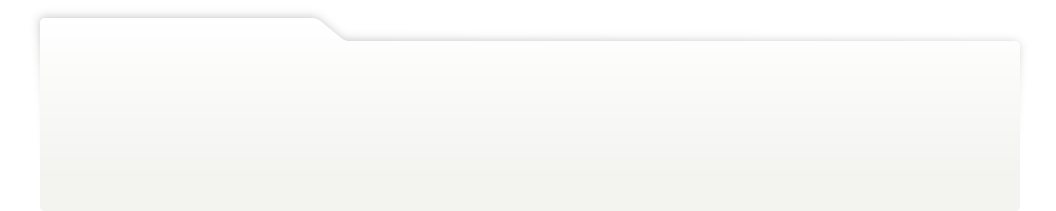
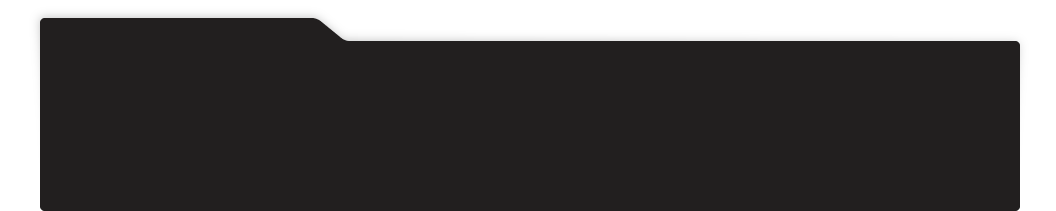
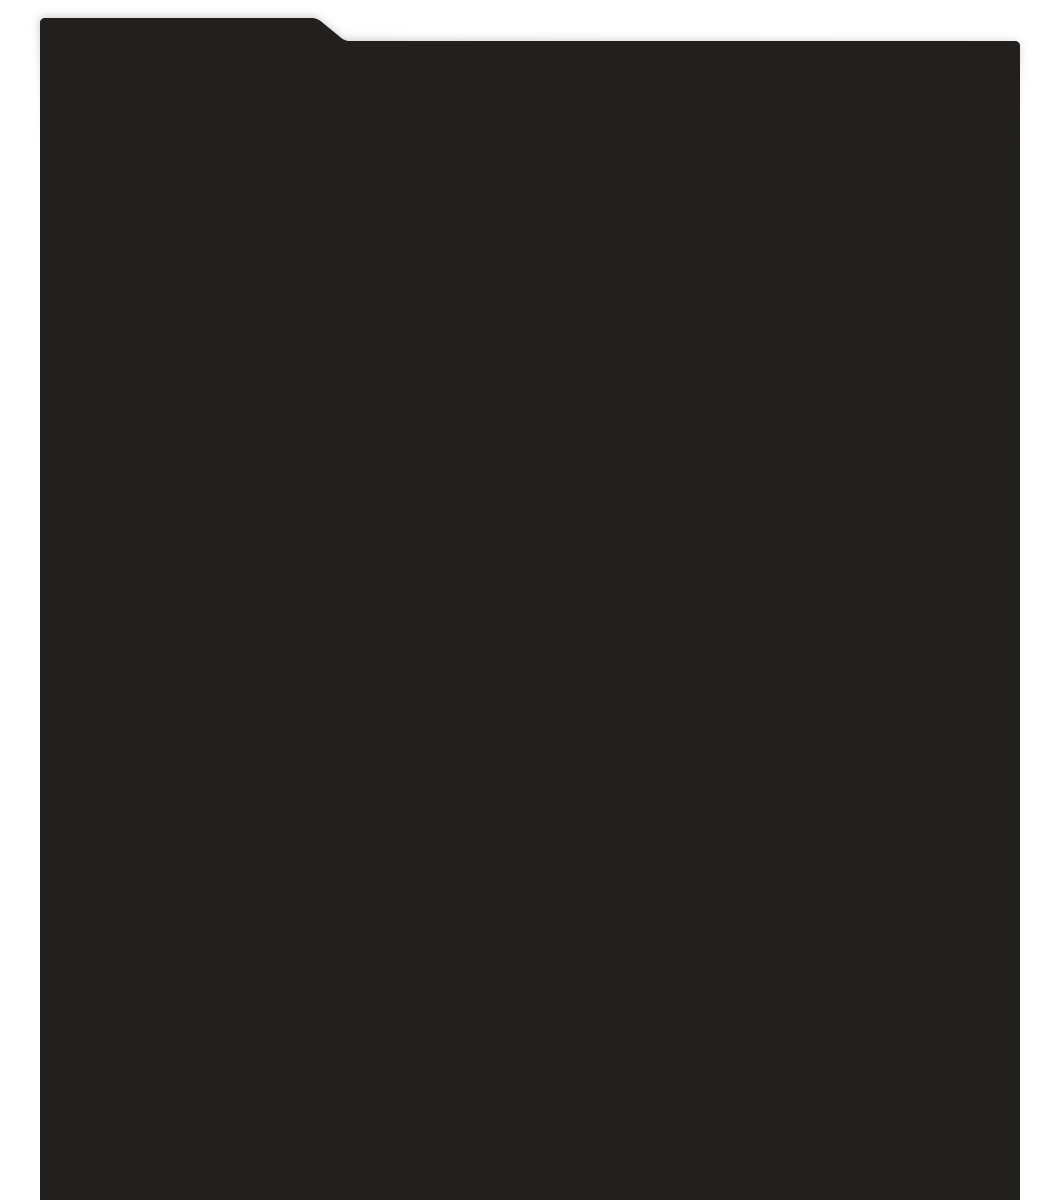
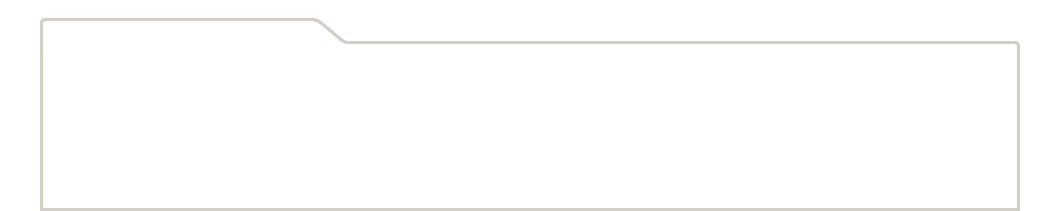
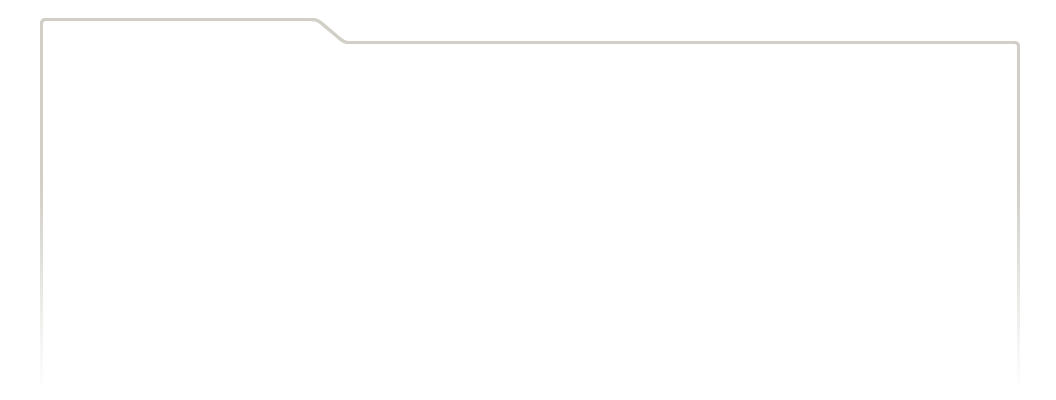
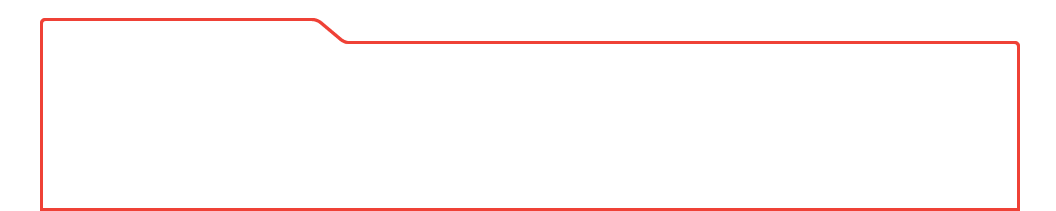
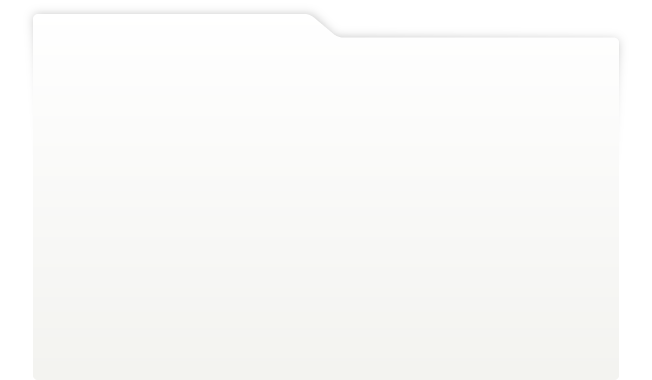
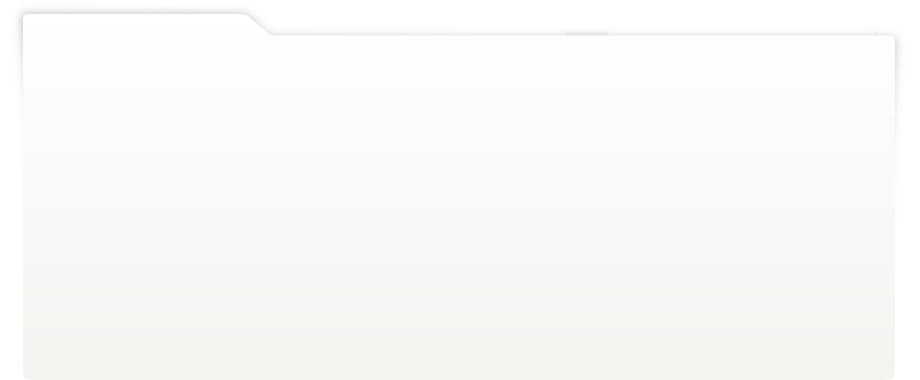
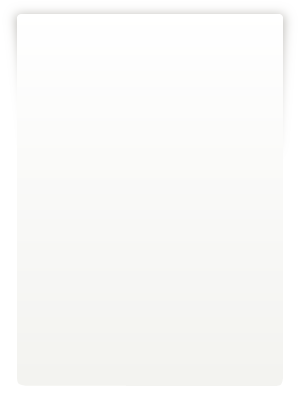
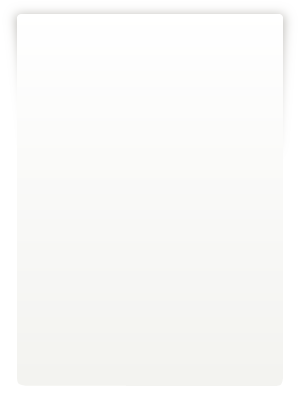
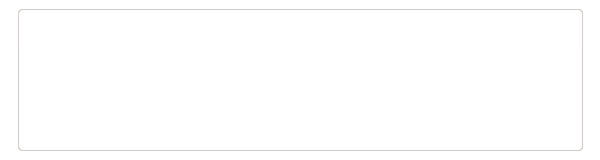
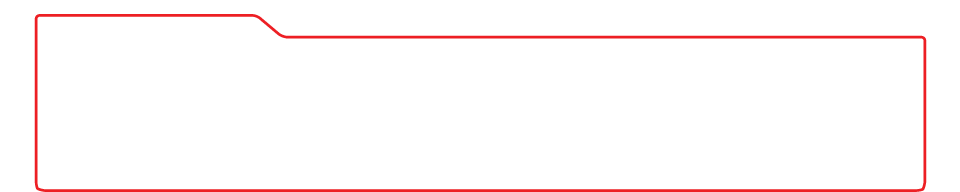
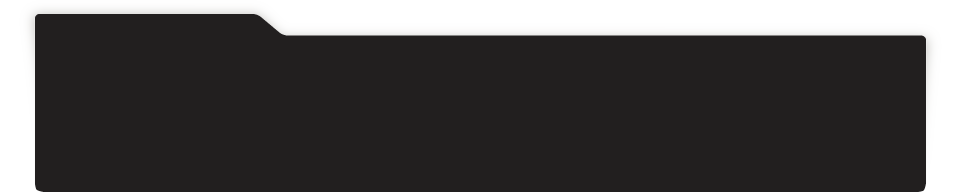
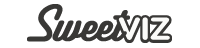
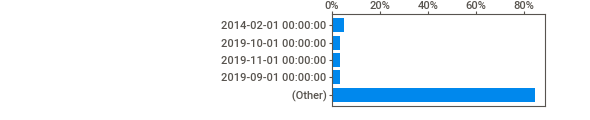
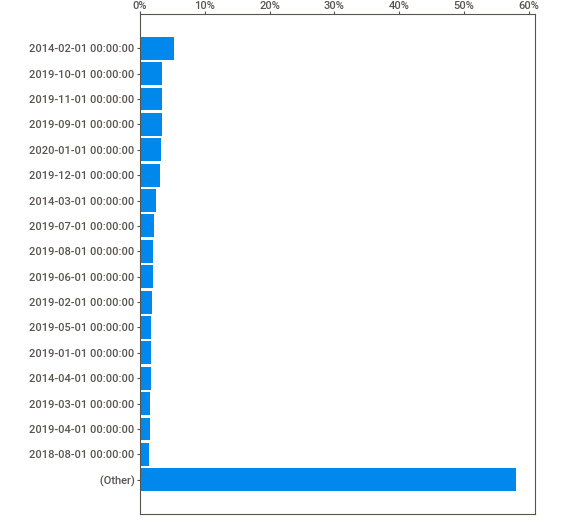
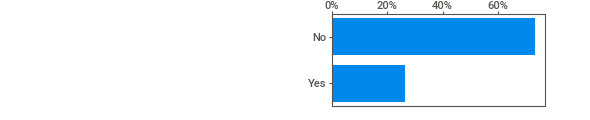
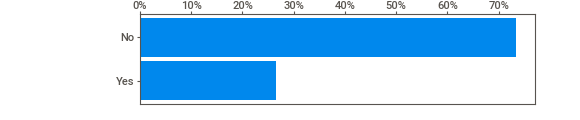
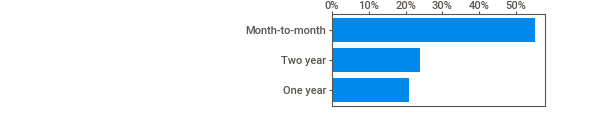
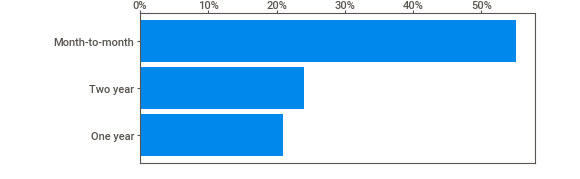
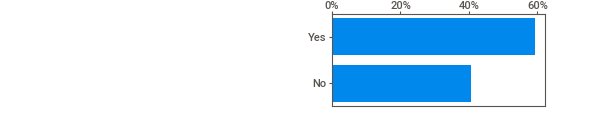
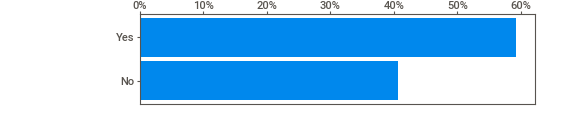
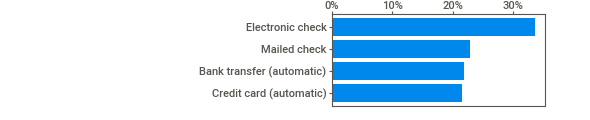
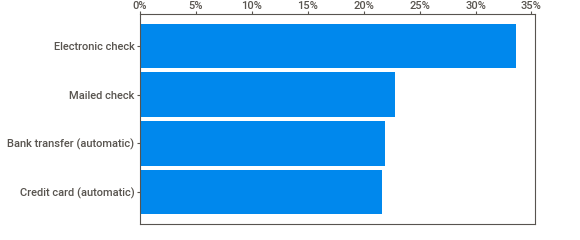
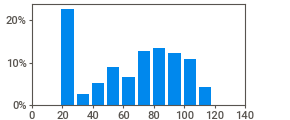
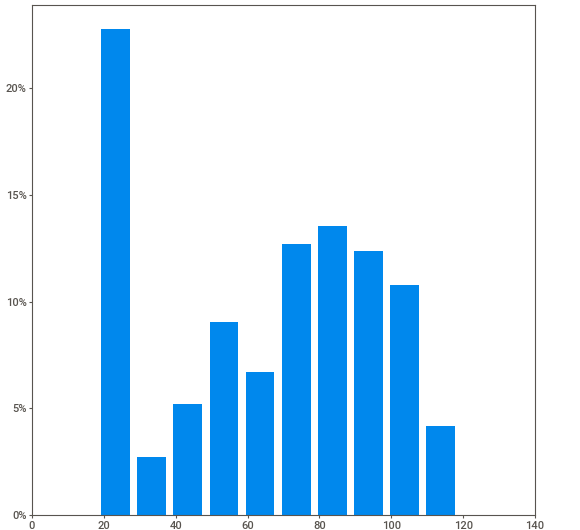
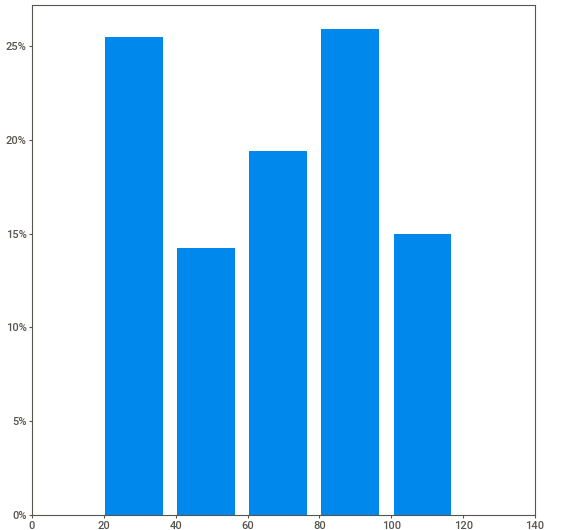
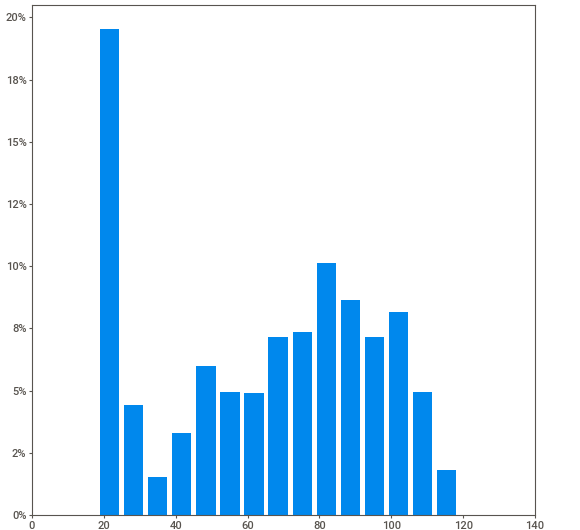
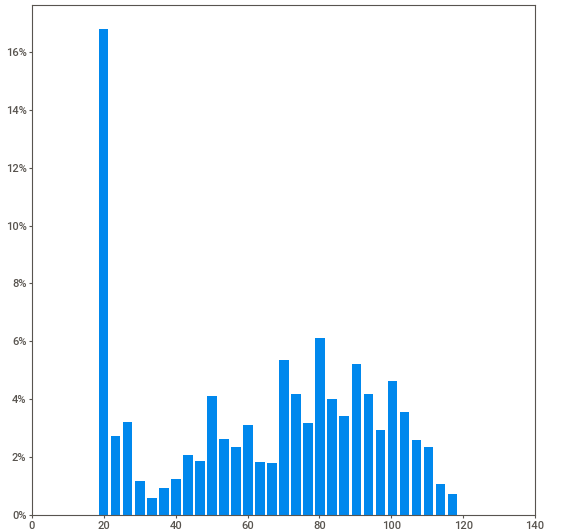
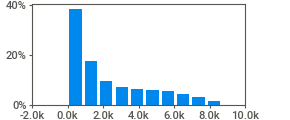
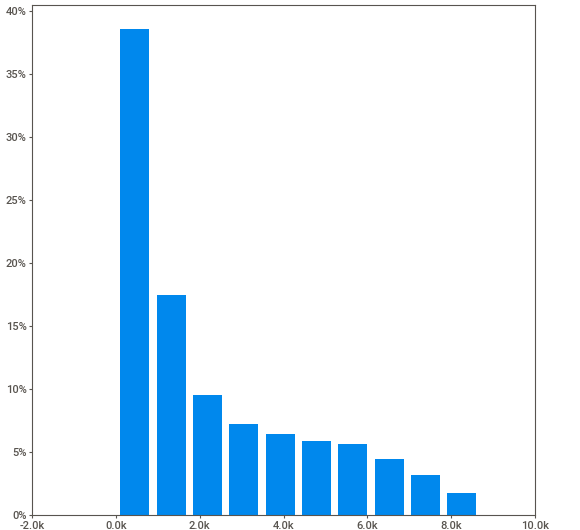
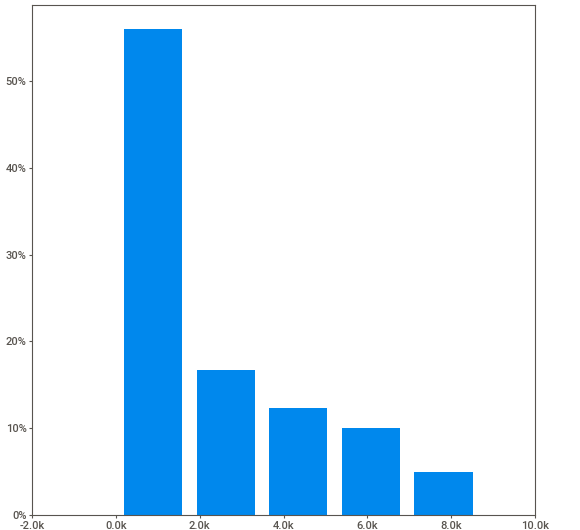
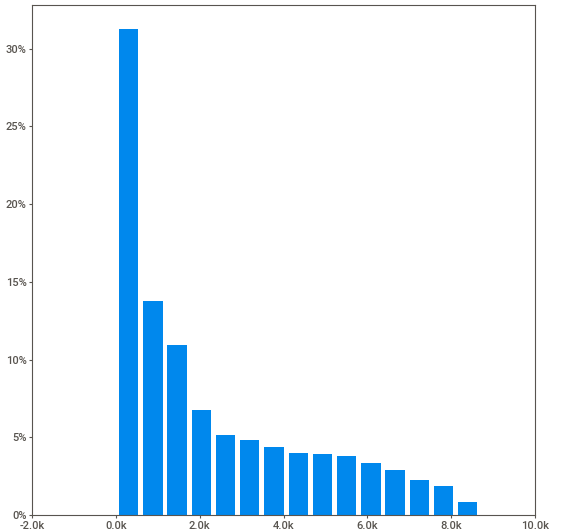
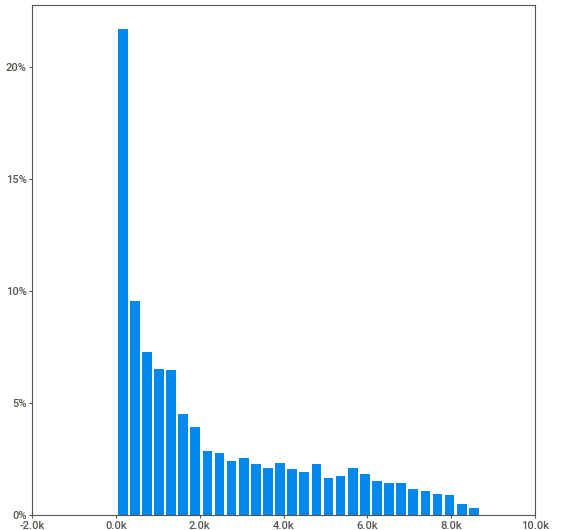
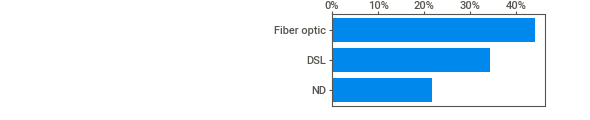
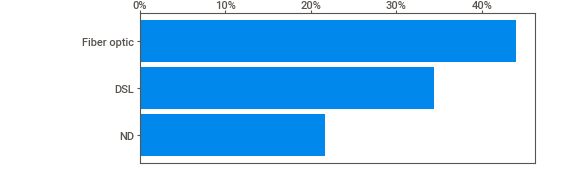
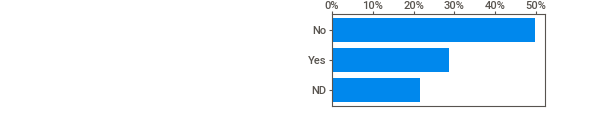
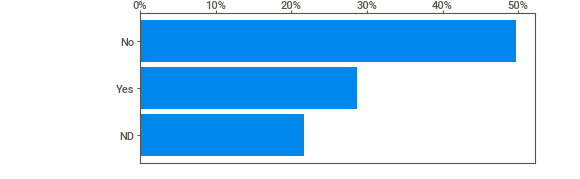
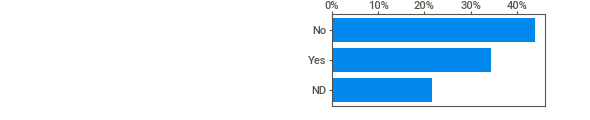
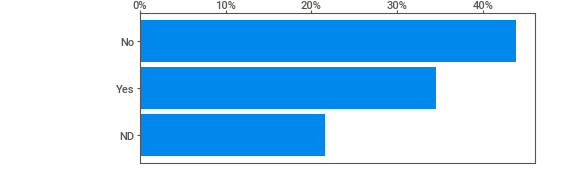
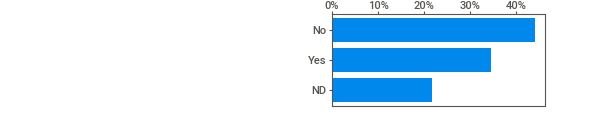
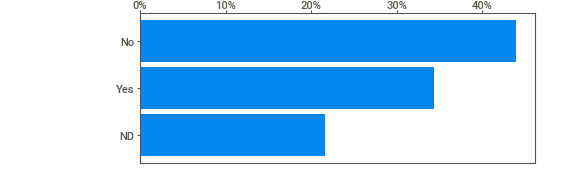
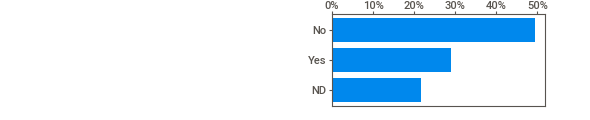
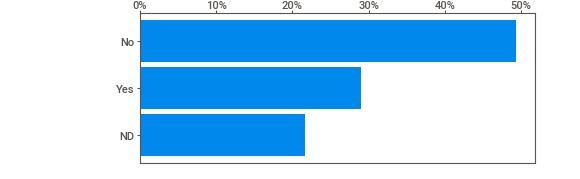
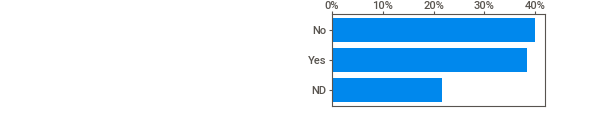
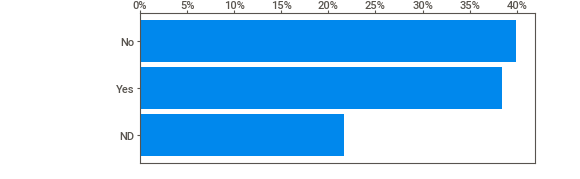
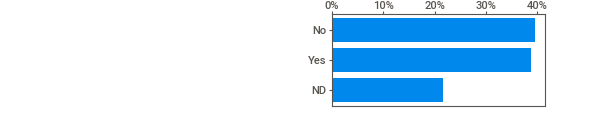
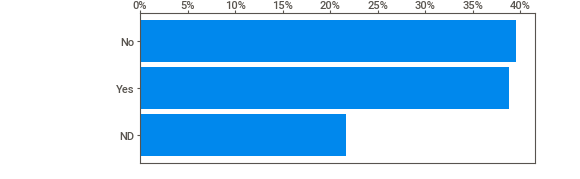
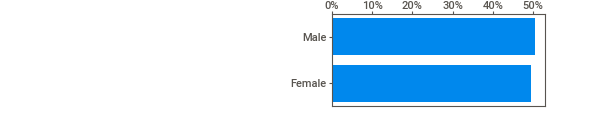
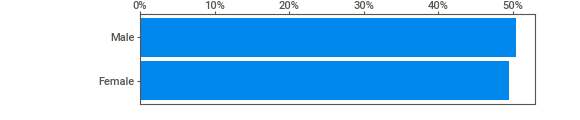
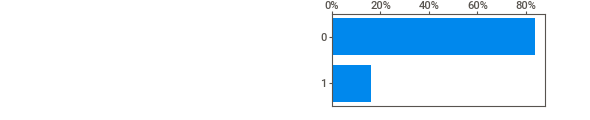
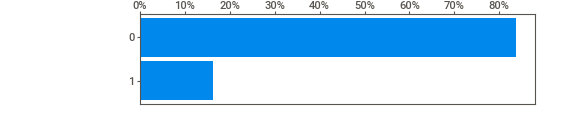
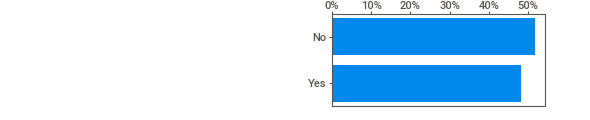
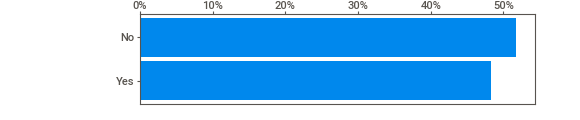
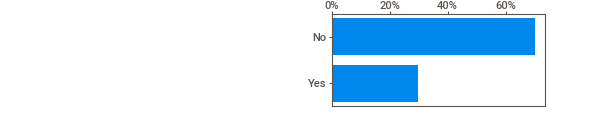
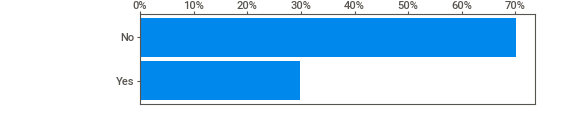
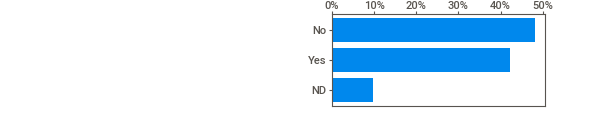
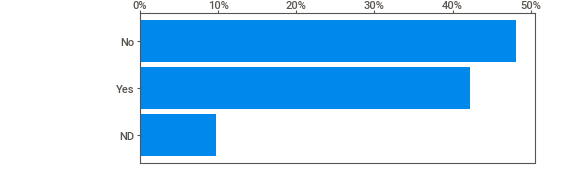
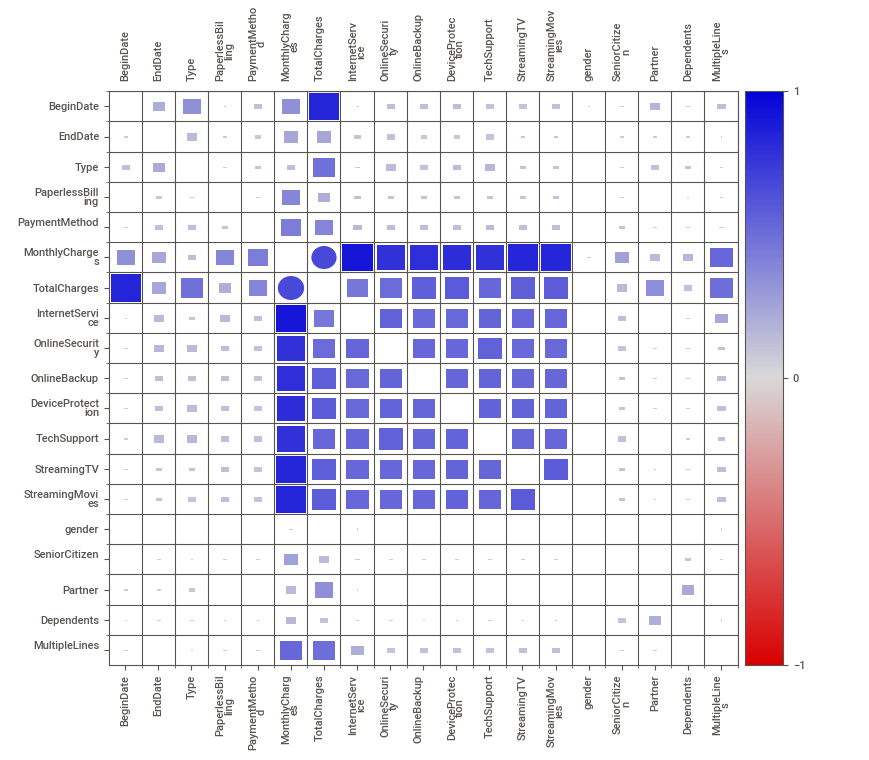
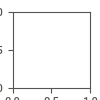

In [27]:
report = sv.analyze([data, 'data'])
report.show_notebook()

### Analysis Conclusions

1. There is a high correlation between TotalCharges and BeginDate. Since in the future we do not take BeginDate as a Feature, we don’t have to worry about this. Again, it’s right that we don’t take it. The longer the client uses the services, the greater his total spending.
2. There is a high correlation between MonthlyCharges and the following data: InternetService, OnlineSecurity, OnlineBackup, DeviceProtaction, TechSupport, StreamingTV, StreamingMovies, MultipleLines, Type. This is quite logical, since the more additional services, the greater the payment for these services.
3. At the same time, there is an internal correlation between these services (InternetService, OnlineSecurity, OnlineBackup, DeviceProtaction, TechSupport, StreamingTV, StreamingMovies, MultipleLines). Most likely, the fact is that when the client has an Internet connection, these services are also connected, with some exceptions. Perhaps it makes sense to remove some of these services from Features for the model, we will solve this later.
4. EndDate (our future target) correlates best with MonthlyCharges and TotalCharges, which is logical, most often customers leave due to high prices for services to the operator where prices are lower. Also, there is a direct symmetrical correlation between MonthlyCharges and TotalCharges. BUT! Since we remember that not all departed clients left at the same moment, we can leave TotalCharges, since this data depends not only on the monthly amount, but also on the time that the person has been a client of the operator.
5. It can be concluded that the main reason for leaving customers is the cost of service, both monthly and total expenses for the entire time of using the services. In addition, one of the reasons for leaving is the Type of contract, it is highly correlated with total spending, since most clients use the Month-to-Month type, which is usually more expensive than annual or biennial.

## Prepare data for model training

#### Divide the data into samples

In [28]:
# Highlight the purpose and signs of learning
features = data.drop(['EndDate', 'BeginDate'], axis=1)
target = data['EndDate']

In [29]:
# Divide the data into training and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE) #, stratify = target)
print (features_train.shape)
print (features_test.shape)

(5274, 17)
(1758, 17)


#### Separate categorical features from quantitative ones

In [30]:
categorical = ['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
              'Dependents', 'MultipleLines']
quantitive = ['MonthlyCharges', 'TotalCharges']

#### Encode categorical features

In [31]:
# for the encoders to work correctly, you need to reset the frame indices
features_train.reset_index(drop=True , inplace=True)
features_test.reset_index(drop=True , inplace=True)

In [32]:
encoder = OrdinalEncoder()

features_train[categorical] = pd.DataFrame(encoder.fit_transform(features_train[categorical]), columns = categorical)
features_test[categorical] = pd.DataFrame(encoder.fit_transform(features_test[categorical]), columns = categorical)

In [33]:
features_train

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,0.0,1.0,0.0,44.65,322.50,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,1.0,1.0,0.0,86.20,3339.05,1.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1.0,1.0,2.0,111.25,7511.65,1.0,2.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,1.0,0.0,2.0
3,0.0,1.0,0.0,100.50,3653.35,1.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,1.0,0.0,2.0
4,1.0,1.0,3.0,24.45,1431.65,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5269,2.0,0.0,2.0,104.70,6333.80,1.0,1.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0
5270,1.0,0.0,1.0,65.60,1010.00,0.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
5271,0.0,1.0,1.0,74.60,548.90,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0
5272,0.0,1.0,3.0,70.15,886.70,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [34]:
features_train.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64

#### Let's scale the numerical features

In [35]:
scaler = StandardScaler()
scaler.fit(features_train[quantitive])

features_train[quantitive] = scaler.transform(features_train[quantitive])
features_test[quantitive] = scaler.transform(features_test[quantitive])

## Model Training

Since we are talking about classification, we will use models with classifiers:
1. First, consider two branched models
- DecisionTreeClassifier (DTC)
- Random Forest Regressor (RFR)

2. And finally, take one gradient boosting model
- Cat Boost Classifier (CBC)



In [36]:
# create scoring for models
SCORING = {'AUC': 'roc_auc', 'Accuracy': 'accuracy'}

### Branching models

#### Decision Tree Classifier

In [37]:
# specify the classifier
DTC = DecisionTreeClassifier(random_state = RANDOM_STATE)

In [38]:
# create parameters for GridSearch
DTC_parameters = { 'max_depth': range (1,25, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

In [39]:
# start GridSearch

DTC_grid = GridSearchCV(DTC, DTC_parameters, cv=5, n_jobs=-1, scoring=SCORING, refit='AUC', return_train_score=True)
DTC_grid.fit(features_train, target_train)

DTC_best_params = DTC_grid.best_params_
DTC_best_index = DTC_grid.best_index_

print ('DTC_best_params:', DTC_best_params)
print ('DTC_best_index:', DTC_best_index)

DTC_best_params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
DTC_best_index: 56


In [40]:
# create a frame from GridSearch results
DTC_results = pd.DataFrame(DTC_grid.cv_results_)

In [41]:
# find the best model metrics
DTC_results = DTC_results.iloc[DTC_best_index]

DTC_best_accuracy = DTC_results['mean_test_Accuracy']
DTC_best_auc = DTC_results['mean_test_AUC']

print ('DTC_best_accuracy:', DTC_best_accuracy)
print ('DTC_best_auc:', DTC_best_auc)

DTC_best_accuracy: 0.7855524879268325
DTC_best_auc: 0.81996923235666


#### Random Forest Classifier

In [42]:
# specify the classifier
RFC = RandomForestClassifier(random_state = RANDOM_STATE)

In [43]:
# create parameters for GridSearch
RFC_parameters = { 'n_estimators': [10, 50, 100], 
                'max_depth': range (1,10, 1),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

In [44]:
# start GridSearch
RFC_grid = GridSearchCV(RFC, RFC_parameters, cv=3, n_jobs=-1, scoring=SCORING, refit='AUC', return_train_score=True)
RFC_grid.fit(features_train, target_train)

RFC_best_params = RFC_grid.best_params_
RFC_best_index = RFC_grid.best_index_

print ('DTC_best_params:', RFC_best_params)
print ('DTC_best_index:', RFC_best_index)

DTC_best_params: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
DTC_best_index: 542


In [45]:
# create a frame from GridSearch results
RFC_results = pd.DataFrame(RFC_grid.cv_results_)

In [46]:
# find the best model metrics
RFC_results = RFC_results.iloc[RFC_best_index]

RFC_best_accuracy = RFC_results['mean_test_Accuracy']
RFC_best_auc = RFC_results['mean_test_AUC']

print ('RFC_best_accuracy:', RFC_best_accuracy)
print ('RFC_best_auc:', RFC_best_auc)

RFC_best_accuracy: 0.7963594994311718
RFC_best_auc: 0.8417733506066427


### Boosting Model

#### CatBoost Classifier

In [47]:
# specify the classifier
CBC = CatBoostClassifier()

In [48]:
# create parameters for GridSearch
CBC_parameters = {'depth'         : [1, 2, 3, 4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04, 0.1],
                  'iterations'    : [10, 50, 100, 200]
                 }

In [49]:
# start GridSearch
CBC_grid = GridSearchCV(CBC, CBC_parameters, cv=3, n_jobs=-1, scoring=SCORING, 
                        verbose=0, refit='AUC', return_train_score=True)
CBC_grid.fit(features_train, target_train) #cat_features=categorical)

CBC_best_params = CBC_grid.best_params_
CBC_best_index = CBC_grid.best_index_

print ('CBC_best_params:', CBC_best_params)
print ('CBC_best_index:', CBC_best_index)

0:	learn: 0.6563341	total: 131ms	remaining: 13s
1:	learn: 0.6261166	total: 132ms	remaining: 6.46s
2:	learn: 0.5994004	total: 133ms	remaining: 4.29s
3:	learn: 0.5781633	total: 133ms	remaining: 3.2s
4:	learn: 0.5580035	total: 134ms	remaining: 2.55s
5:	learn: 0.5425501	total: 135ms	remaining: 2.11s
6:	learn: 0.5281511	total: 136ms	remaining: 1.8s
7:	learn: 0.5154644	total: 137ms	remaining: 1.57s
8:	learn: 0.5058477	total: 137ms	remaining: 1.39s
9:	learn: 0.4974620	total: 138ms	remaining: 1.24s
10:	learn: 0.4910986	total: 139ms	remaining: 1.12s
11:	learn: 0.4829490	total: 139ms	remaining: 1.02s
12:	learn: 0.4757591	total: 140ms	remaining: 939ms
13:	learn: 0.4700855	total: 141ms	remaining: 866ms
14:	learn: 0.4656114	total: 142ms	remaining: 804ms
15:	learn: 0.4602424	total: 143ms	remaining: 749ms
16:	learn: 0.4558679	total: 143ms	remaining: 700ms
17:	learn: 0.4516096	total: 144ms	remaining: 657ms
18:	learn: 0.4485053	total: 145ms	remaining: 619ms
19:	learn: 0.4453629	total: 146ms	remaining: 

In [50]:
# create a frame from GridSearch results
CBC_results = pd.DataFrame(CBC_grid.cv_results_)

In [51]:
# find the best model metrics
CBC_results = CBC_results.iloc[CBC_best_index]

CBC_best_accuracy = CBC_results['mean_test_Accuracy']
CBC_best_auc = CBC_results['mean_test_AUC']

print ('CBC_best_accuracy:', CBC_best_accuracy)
print ('CBC_best_auc:', CBC_best_auc)

CBC_best_accuracy: 0.8014789533560864
CBC_best_auc: 0.845698565540097


### Model comparison

In [52]:
new_index = ['DTC', 'RFC', 'CBC']
metrics = pd.DataFrame ({'Accuracy': [DTC_best_accuracy, RFC_best_accuracy, CBC_best_accuracy],
                        'AUC_ROC': [DTC_best_auc, RFC_best_auc, CBC_best_auc]}, index = new_index)

metrics

,Accuracy,AUC_ROC
DTC,0.785552,0.819969
RFC,0.796359,0.841773
CBC,0.801479,0.845699


### Choosing the best model

The CatBoostClassifier gradient boosting model turned out to be the best model. It showed the highest accuracy (accuracy) and the AUC_ROC metric that we need. Also, despite the fact that it takes longer to check against GridSeachCV, it will perform faster than the random forest model in the future.

## Model checking on the test data

### Test the selected model

In [53]:
print ('CBC_best_params:', CBC_best_params)

CBC_best_params: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}


In [54]:
model = CatBoostClassifier(depth=4, iterations=100, learning_rate=0.1, verbose=0)    
    
model.fit(features_train, target_train)
predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print ('Test Accuracy:', accuracy)

Test Accuracy: 0.8071672354948806


In [55]:
# сразу посчитаем метрику AUC-ROC
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print ('Test AUC_ROC:', auc_roc)

Test AUC_ROC: 0.8523214760577138


## Feature importance

### Importance of features by its decrease

In [56]:
model = CatBoostClassifier(depth=4, iterations=100, learning_rate=0.1, verbose=0)  
model.fit(features_train, target_train)

importance = model.feature_importances_  

feature_list = list(features_train.columns)  
feature_results = pd.DataFrame({'feature': feature_list,'importance': importance})  
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)  
feature_results

,feature,importance
0,Type,26.667555
1,TotalCharges,21.707719
2,MonthlyCharges,9.097744
3,InternetService,7.424430
4,OnlineSecurity,6.015674
5,OnlineBackup,5.415637
6,DeviceProtection,4.570204
7,TechSupport,4.313321
8,PaymentMethod,3.367086
9,PaperlessBilling,2.280656


### Graph of the importance of features for clarity

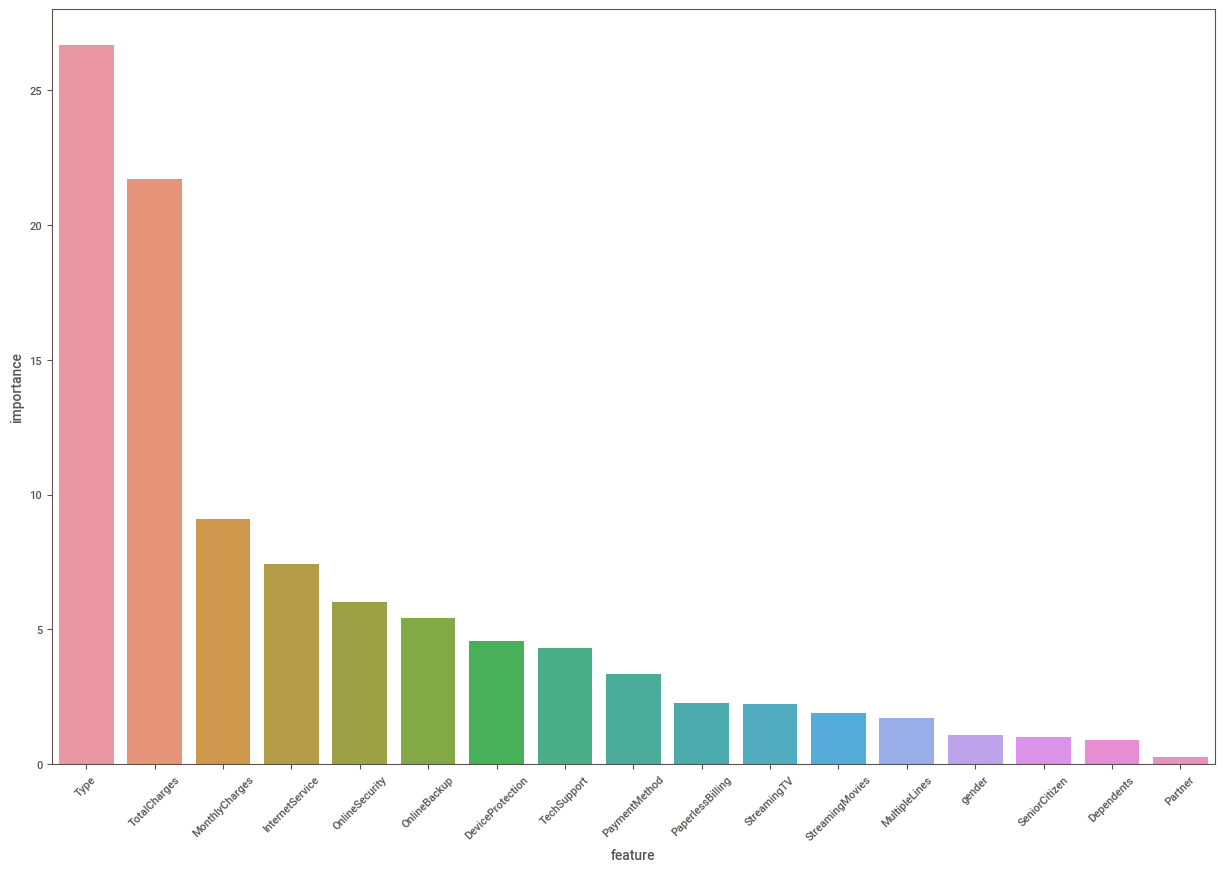

In [57]:
plt.figure(figsize=(15,10))
sns.barplot(x="feature", y="importance", data=feature_results)
plt.xticks(np.arange(17), feature_results['feature'], rotation=45)
plt.show()

The most important feature is the type of contract, the second after it is the amount of spending by the client in general over the term of the contract, and the most "useless" feature for the model is whether the client has a spouse or not.

## General conclusion

1. Data is open and explored.
2. The tables are merged by the values of the customerID column.
3. An analysis of multicollinearity and business analysis of possible reasons for the departure of clients was carried out.
4. The data is divided into training and test sets (3/1).
5. The goals and signs of learning are highlighted (the goal is EndDate - the client left or not).
6. Encoded data in the training sample, which are specified as object in the digital display of categorical variables.
7. The data in the test sample is coded separately.
8. Trained several models including tree models, forest and gradient boosting (CatBoost). Cross-validation has been carried out.
8. It was determined that the CatBoost model was the best fit for our data.
9. The best model (CatBoost) was tested on the test sample, the accuracy metric was calculated, its result is 0.807, which is more than with cross-validation.
10. The AUC-ROC metric on the test sample is 0.852, which means that our classifier will be able to distinguish between positive and negative class values. This is because the classifier can detect more true positives and true negatives than false negatives and false positives.
11. We analyzed the signs by which the model makes predictions, and it was found that the most important sign is the type of contract, the second after it is the amount of spending per month by the client, and the most "useless" for the model is whether the client has a spouse or not .

## Report

**Report Questions**

1. Which points of the plan were completed and which were not. Why?
2. What difficulties did you encounter and how did you overcome them?
3. What are the key steps in solving the task that you identified?
4. What features were used to train the model and what kind of preprocessing of these features was performed?
5. What is your final model, what are its hyperparameters and what is its quality?

### Completed plan items

1. Data is open and explored.
2. Data analysis was carried out.
3. The data for training the model is prepared.
4. 3 models were trained and cross-validated, the best model was chosen.
5. The result of the work of the best model in terms of the AUC-ROC metric on the test sample is considered.
6. Considered the importance of features for the model.
7. A general conclusion is written.
- All points of the plan are fulfilled.

### Difficulties encountered during work

The main difficulty was in the correct choice of the model and the selection of hyperparameters, as well as in the choice of preprocessing, whether it is necessary to remove any columns from the features, whether scaling is needed, whether stratify is needed. All this greatly influenced the final results in AUC-ROC, so most of the time was spent on choosing one or another option for the settings described above.

### Key steps in task solving

1. Consolidation of data into one table, work with gaps.
2. Data analysis for multicollinearity, interaction of data with the target.
3. Encoding and data scaling.
4. Selection of several models, selection of hyperparameters, cross-validation.
5. Choosing the best model.
6. Testing the best model.
7. Studying the importance of features.

### Features used to train the model

- Target feature
1. EndDate - the dates of departed clients are replaced with Yes (the client just left), paired with No, 2 classes were obtained.

- Signs for learning (in decreasing order of importance)
1. Type - encoded into a numerical form.
2. TotalCharges - removed lines in which the client had just arrived at the time of studying the data (11 pieces). Scaling done.
3. MonthlyCharges - scaling has been done.
4. InternetService - Omissions changed to 'ND' (not defined). Carried out coding in numerical form.
5. OnlineSecurity - Omissions changed to 'ND' (not defined). Carried out coding in numerical form.
6. OnlineBackup - Omissions changed to 'ND' (not defined). Carried out coding in numerical form.
7. DeviceProtection - Omissions changed to 'ND' (not defined). Carried out coding in numerical form.
8. TechSupport - Omissions changed to 'ND' (not defined). Carried out coding in numerical form.
9. PaymentMethod - coding in numerical form is carried out.
10. PaperlessBilling - coding was carried out in numerical form.
11. StreamingTV - Omissions changed to 'ND' (not defined). Carried out coding in numerical form.
12. StreamingMovies - Omissions changed to 'ND' (not defined). Carried out coding in numerical form.
13. MultipleLines - Changed gaps to 'ND' (not defined). Carried out coding in numerical form.
14. gender - encoded into a numerical form.
15. Senior Citizen - coded in numerical form.
16. Dependents - coding was carried out in a numerical form.
17. Partner - coding was carried out in a numerical form.

### Final model

- The final model was the CatBoostClassifier gradient boosting model with hyperparameters: 'depth': 4, 'iterations': 100, 'learning_rate': 0.1.
- Final metric AUC_ROC = 0.852.
- Final metric Accuracy = 0.807.